# Recommender System
In this notebook we will take a look at how to perform collaborative filtering to create a recommender system that can suggest new anime for people to watch. This notebook is just a summary of my notes and some code for data exploration and prototyping purposess.

## What is a Recommender System Anyways?

If you have the time, I suggest you watch this <a href="https://www.youtube.com/watch?v=ZspR5PZemcs">video</a> which does a really good job explaining recommendation systems and how companies like Netflix, Spotify and Amazon are putting it to use. 

Of course, if you're short on time and want my dumb downed explanation, please continue reading below.

## The Problem

The problem we are trying to solve here is one of rating predictions. Let's assume we have a dataset that contains all the ratings history of multiple users, we can use this data to build a sparse matrix as follows:

<img src="./pics/sparse_matrix.png" width=60%/>

**Our goal is to predict the ratings of the missing entries, which are also the movies that have not been watched by the user.**

## Enter Matrix Factorization

So turns out their are many different techniques that have been used to solve our problem, but in this notebook we will focus on matrix factorization, which is a technique that was heavily influenced by a well known linear algebra algorithm called Singular Value Decomposition (SVD).

First, let us go back and explain what **factorizing** means. Basically, it means breaking down a component into smaller, more manageable components. In the case of our matrix above, we are going to break it down into two smaller components.

For example, let's say that Alice can be defined as an action fan and comedy fan. Meanwhile Bob is a horror and action fan...
```
Alice = 50% Action + 50% Comedy + 0% Horror
Bob = 50% Action + 0% Comedy + 50% Horror
```
We can also break down our movies to types of genres. For example, "toy story" is a mix of action, adventure and comedy. Meanwhile "the ring" is a mixture of horror and action.
```
Toy Story = 50% Action + 25% Adventure + 25% Comedy + 0% Horror
The Ring = 50% Action + 0% Adventure + 0% Comedy + 0% Horror
```
Based on this information, we can easily tell that Alice is going to rate toy story higher than she rates the ring and vice versa for Bob.

This is the basic idea behind matrix factorization, we are trying to **break down the user-rating matrix** into two smaller matrices: **user-genre matrix** and **movie-genre matrix.**

<img src ="./pics/matrix-factorization.png"/>

# The Data

In this section we will actually build our own anime recommendation system. The data was mined from the <a href="https://myanimelist.net">myanimelist website </a>. All the hard work was done by "Azathoth", and the dataset is available for free <a href="https://www.kaggle.com/azathoth42/myanimelist">here.</a>

In [1]:
import pandas as pd
import surprise
from jikanpy import Jikan
import numpy as np
import time

# To create deep learning models
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout, Flatten, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform, Ones, RandomNormal
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [2]:
# The dataset, anime_id_title.csv contains a mapping between the anime's title and an integer value

anime_id_map = pd.read_csv('./data/anime_id_title.csv')
anime_id_map.head()

id_2_title = {id: title for id, title in zip(anime_id_map.anime_id, anime_id_map.title)}
title_2_id = {title: id for id, title in zip(anime_id_map.anime_id, anime_id_map.title)}

In [3]:
df = pd.read_csv('./data/user_ratings.csv')
df = df[['username','anime_id','my_score']]

#Map username to userID
username_to_id = {username: id for id, username in enumerate(df.username.unique())}
id_to_username = {id: username for id, username in enumerate(df.username.unique())}

df['username'] = df['username'].map(username_to_id)

In [4]:
# Anime cleaned contains details of all the anime within the dataset including the most highly ranked anime.
# If we run into the 'cold start' problem, we will suggest the most highly ranked anime for the user to watch.
anime_cleaned = pd.read_csv('./data/anime_cleaned.csv')
anime_cleaned = anime_cleaned[['title','score','scored_by','rank']]
anime_cleaned.head()

,title,score,scored_by,rank
0,Inu x Boku SS,7.63,139250,1274.0
1,Seto no Hanayome,7.89,91206,727.0
2,Shugo Chara!! Doki,7.55,37129,1508.0
3,Princess Tutu,8.21,36501,307.0
4,Bakuman. 3rd Season,8.67,107767,50.0


## Data Cleaning:

Our current dataset is too large and takes too long for our machine learning algorithm to compute. Therefore, we are going to reduce the size of the algorithm by following a couple steps:
- Remove anime that have less than or equal to 5000 ratings
- Remove user's that have less than or equal to 10 reviews
- Randomly select 5000 users to be part of the recommendation system.

One of the main drawbacks from reducing the size of our database is that we are also removing some rare anime from the dataset. Hence, we are only going to be able to recommend the more popular anime.

In [5]:
#anime with less than 10 ratings
reviews_per_anime = df.groupby('anime_id').count()
anime_few_reviews = reviews_per_anime[reviews_per_anime.username <= 5000].index.to_list()

#user's with less than 10 reviews
review_per_user = df.groupby('username').count()
users_few_reviews = review_per_user[review_per_user.anime_id <= 10].index.to_list()

#Remove anime with less than 10 ratings
df = df[~df['anime_id'].isin(anime_few_reviews)]

#Remove user's with less than 10 reviews
df = df[~df['username'].isin(users_few_reviews)]

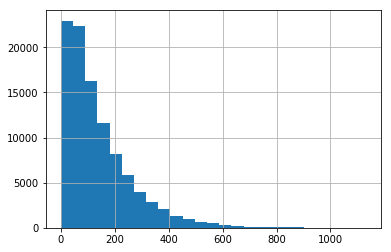

In [6]:
#How many users are in the database? 108249

#Check the distribution of ratings per user
df.groupby('username').count().anime_id.hist(bins=25)

1178


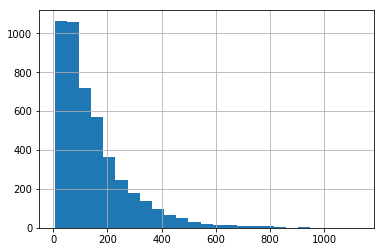

In [7]:
print(len(df.anime_id.unique()))
#Reduce the number of users in our data by randomly selecting 5000 ppl to include in our databasse
index = np.random.randint(low=0, high=len(df.username.unique()), size=5000)
df = df[df.username.isin(index)]

#Recheck our distribution of ratings per user to see if the random downsampling messed anything up
df.groupby('username').count().anime_id.hist(bins=25)

## Using Scikit-Surprise recommendation system

In [8]:
#According to surprise documentation: 
#https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset
df = df.rename(columns={'username':'userID', 'anime_id':'itemID', 'my_score':'rating'})
reader = surprise.Reader(rating_scale=(0,10))
data = surprise.Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
algo = surprise.SVD()

#Train test split
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
start = time.time()
algo.fit(trainset)
end = time.time()
print("Train time: {}".format(end - start))

start = time.time()
predictions = algo.test(testset)
end = time.time()
print("Prediction time: {}".format(end - start))

# Then compute MAE
surprise.accuracy.mae(predictions)

Train time: 27.625802040100098
Prediction time: 1.4746990203857422
MAE:  1.2666


1.266607061361212

In [9]:
surprise.model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9107  1.9117  1.9054  1.9068  1.9060  1.9081  0.0026  
MAE (testset)     1.2620  1.2608  1.2594  1.2589  1.2610  1.2604  0.0011  
Fit time          29.52   29.66   29.64   29.63   29.64   29.62   0.05    
Test time         1.15    1.12    1.12    1.13    1.14    1.13    0.01    


{'test_rmse': array([1.9106543 , 1.91166045, 1.90539679, 1.90683248, 1.90599302]),
 'test_mae': array([1.26200761, 1.26084458, 1.25941411, 1.25893148, 1.26101031]),
 'fit_time': (29.521589040756226,
  29.662222862243652,
  29.64219903945923,
  29.625389099121094,
  29.64243459701538),
 'test_time': (1.152869701385498,
  1.1242239475250244,
  1.1205189228057861,
  1.1302509307861328,
  1.13873291015625)}

## Building a recommendation system with Keras

We implement a simple matrix factorization algorithm in Keras. One thing we add to this algorithm is user bias which tries to take into account the fact that some users tend to rate movies more extremely (i.e. all 10's and all 0's).

In [10]:
anime_mapping = {id: i for i, id in enumerate(df.itemID.unique())}
user_mapping = {id: i for i, id in enumerate(df.userID.unique())}

df['anime_mapping'] = df['itemID'].map(anime_mapping)
df['user_mapping'] = df['userID'].map(user_mapping)

#Train test split
df = df.sample(frac=1).reset_index(drop=True)

# Testingsize
n = 150000

# Split train- & testset
df_train = df[:-n]
df_test = df[-n:]

In [11]:
num_users = len(user_mapping)
num_anime = len(anime_mapping)
embedding_size = 30

### Create Model ###
user_input = Input(shape = (1,), name = 'user_input')
anime_input = Input(shape = (1,), name = 'anime_input')

user_embedding = Embedding(input_dim = num_users + 1,
                           output_dim = embedding_size,
                           name = 'user_embedding',
                           input_length=1,
                           embeddings_initializer = glorot_uniform())(user_input)

user_bias = Embedding(input_dim = num_users + 1,
                     output_dim = 1,
                     name = "user_bias")(user_input)

anime_embedding = Embedding(input_dim = num_anime + 1,
                            output_dim = embedding_size,
                            name = 'anime_embedding',
                            input_length=1,
                            embeddings_initializer = glorot_uniform())(anime_input)

anime_bias = Embedding(input_dim = num_users + 1,
                      output_dim = 1,
                      name = 'anime_bias')(anime_input)

prod = Multiply(name = "product")([user_embedding, anime_embedding])
y = Concatenate(axis = -1)([prod, user_bias, anime_bias])
y = Dropout(0.25)(y)
y = Flatten()(y)
y = Dense(64, activation='relu')(y)
y = Dense(1, activation='linear')(y)

model = Model(inputs = [user_input, anime_input], outputs = y)
model.compile('adam', 'mae', metrics=['mae'])


In [12]:
print("Start Training...")
start = time.time()
model.fit([df_train.user_mapping, df_train.anime_mapping],
          df_train.rating, batch_size=256, epochs=5, shuffle=True)
end = time.time()
print("Training time = {}s".format(end - start))

Start Training...
Epoch 1/5
532573/532573 [==============================] - 5s 9us/sample - loss: 1.9139 - mae: 1.9139
Epoch 2/5
532573/532573 [==============================] - 4s 8us/sample - loss: 1.2715 - mae: 1.2715 1s - loss:
Epoch 3/5
532573/532573 [==============================] - 4s 8us/sample - loss: 1.1988 - mae: 1.1988
Epoch 4/5
532573/532573 [==============================] - 5s 9us/sample - loss: 1.1508 - mae: 1.1508
Epoch 5/5
532573/532573 [==============================] - 4s 8us/sample - loss: 1.1186 - mae: 1.1186 0s - loss: 1
Training time = 22.689926862716675s


In [13]:
predictions = model.predict([df_test.user_mapping, df_test.anime_mapping])

In [14]:
# Compute mae
mae = mean_absolute_error(predictions, df_test.rating)
mae

1.2204188338549933

## Monte Carlo Simulation
We will perform random shuffles on the data and retrain our machine learning model for a number of trails. This is a good way of measuring the performance of our model.

In [15]:
results = []

#Run a monte carlo simulation to measure the performance of our machine learning model
print("Starting Simulation:")
start = time.time()
for i in range(5):
    #Train test split
    df = df.sample(frac=1).reset_index(drop=True)

    # Testingsize
    n = 150000

    # Split train- & testset
    df_train = df[:-n]
    df_test = df[-n:]
    
    ### Model Creation ###
    num_users = len(user_mapping)
    num_anime = len(anime_mapping)
    embedding_size = 30
    user_input = Input(shape = (1,), name = 'user_input')
    anime_input = Input(shape = (1,), name = 'anime_input')
    user_embedding = Embedding(input_dim = num_users + 1, 
                               output_dim = embedding_size,
                               name = 'user_embedding',
                               input_length=1,
                               embeddings_initializer = RandomNormal())(user_input)
    
    user_bias = Embedding(input_dim = num_users + 1,
                         output_dim = 1,
                         name = 'user_bias',
                         embeddings_initializer = RandomNormal())(user_input)
    
    anime_embedding = Embedding(input_dim = num_anime + 1,
                                output_dim = embedding_size,
                                name = 'anime_embedding',
                                input_length=1,
                                embeddings_initializer = RandomNormal())(anime_input)
    
    anime_bias = Embedding(input_dim = num_anime + 1,
                          output_dim = 1,
                          name = "anime_bias",
                          embeddings_initializer = RandomNormal())(anime_input)
    
    prod = Multiply(name = "product")([user_embedding, anime_embedding])
    
    y = Concatenate(axis = -1)([prod, user_bias, anime_bias])
    y = Dropout(0.5)(y)
    y = Flatten()(y)
    y = Dense(64, activation = 'relu')(y)
    y = Dense(1, activation = 'linear')(y)
    model = Model(inputs = [user_input, anime_input], outputs = y)
    model.compile('adam', 'mae', metrics=['mae'])
    
    ### Model Training ###
    model.fit([df_train.user_mapping, df_train.anime_mapping],
              df_train.rating, batch_size=512, epochs=5, shuffle=True, verbose = 0)
    
    ### Model Predictions ###
    predictions = model.predict([df_test.user_mapping, df_test.anime_mapping])
    mae = mean_absolute_error(predictions, df_test.rating)
    results.append(mae)

end = time.time()
print("Duration: {}s".format(end-start))    
print(results)

Starting Simulation:
Duration: 69.76071667671204s
[1.214333754128019, 1.2405123022973537, 1.2205749560007453, 1.2072134682349365, 1.2091823255779346]


# Conclusions
In this notebook we created a recommendation system using the matrix factorization method. First, we made use of the scikit-surprise library, which has a pre-built implementation of the SVD algorithm for recommendation purposes. Then, we implemented our own algorithm using keras.

In conclusion, both algorithms have very similar performance metrics and training time. (~1.2 MAE and 20 - 30s train time).